# Using SQL to explore the Chinook record sales database

In [2]:
# import modules
%matplotlib inline
import numpy as np
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
from matplotlib import cm

In [3]:
db = 'chinook.db'

def run_query(query):
    '''takes in a SQL query and returns a pandas dataframe of the query'''
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query,conn)
    
def run_command(command):
    '''takes in a SQL command and executes it'''
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(command)
        
def show_tables():
    '''calls run_query to return a list of all tables and views in the database'''
    query = '''SELECT name, type 
               FROM sqlite_master 
               WHERE type IN ('table','view');'''
    return run_query(query)

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Select the three new albums (genres Hip-Hop, Punk, Pop, and Blues) to be sold at the store based on which genres sell best in the USA

In [5]:
query = '''
        WITH genre_table AS
        (
        SELECT g.name as genre,
               COUNT(il.invoice_line_id) num_tracks_sold
        FROM genre g
        LEFT JOIN track t ON t.genre_id = g.genre_id
        LEFT JOIN invoice_line il ON il.track_id = t.track_id
        LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
        LEFT JOIN customer c ON c.customer_id = i.customer_id
        WHERE (c.country = "USA" AND 
              (LOWER(genre) LIKE '%hip%' OR 
              LOWER(genre) LIKE '%punk%' OR 
              LOWER(genre) LIKE '%pop%' OR
              LOWER(genre) LIKE '%blues%'))
        GROUP BY genre
        ORDER BY num_tracks_sold DESC
        )
        
        SELECT genre,
               num_tracks_sold,
               100*CAST(num_tracks_sold AS float)/(SELECT SUM(num_tracks_sold) FROM genre_table) pct_tracks_sold
        FROM genre_table
        '''

genre_sales_usa = run_query(query)
genre_sales_usa

,genre,num_tracks_sold,pct_tracks_sold
0,Alternative & Punk,130,62.500000
1,Blues,36,17.307692
2,Pop,22,10.576923
3,Hip Hop/Rap,20,9.615385


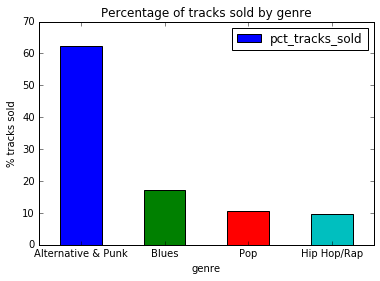

In [6]:
genre_sales_usa.plot.bar(x='genre',y='pct_tracks_sold',rot=0)
plt.title("Percentage of tracks sold by genre")
plt.ylabel("% tracks sold")

Since Punk, Blues, and Pop sell the most out of the four genres in consideration, we recommend selecting albums with these genres.

### Find which sales support agents generate the most revenue

In [7]:
query = '''
        SELECT DISTINCT(title)
        FROM employee as e'''

employee_titles = run_query(query)
employee_titles

,title
0,General Manager
1,Sales Manager
2,Sales Support Agent
3,IT Manager
4,IT Staff


In [8]:
query = '''
    SELECT e.first_name || " " || e.last_name name,
           e.hire_date,
           COUNT(DISTINCT(c.customer_id)) as num_customers,
           CASE WHEN i.total > 0 THEN SUM(i.total) ELSE 0 END total_sales_dollars
    FROM employee as e
    LEFT JOIN customer c ON c.support_rep_id = e.employee_id
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    WHERE e.title = "Sales Support Agent"
    GROUP BY name
    '''
employee_sales = run_query(query)
employee_sales

,name,hire_date,num_customers,total_sales_dollars
0,Jane Peacock,2017-04-01 00:00:00,21,1731.51
1,Margaret Park,2017-05-03 00:00:00,20,1584.00
2,Steve Johnson,2017-10-17 00:00:00,18,1393.92


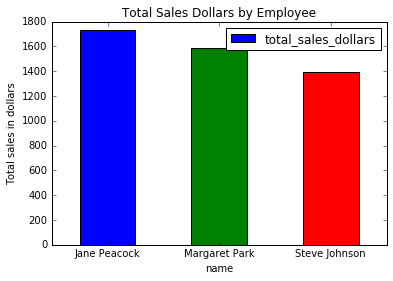

In [9]:
employee_sales.plot.bar(x="name",y="total_sales_dollars",rot=0)
plt.title("Total Sales Dollars by Employee")
plt.ylabel("Total sales in dollars")

It looks like Jane had the highest total revenue, followed by Margaret and Steve.  However Jane had the earliest start date, followed by Margaret and Steve, so these sales employees might be generating total revenue at similar rates.

### Analyze sales data by country; for each country calculate
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [10]:
query = '''
        WITH country_table AS
        (
        SELECT
            c.country,
            COUNT(DISTINCT(c.customer_id)) num_customers,
            SUM(i.total) tot_sales_value,
            COUNT(DISTINCT(invoice_id)) num_orders
        FROM customer c
        LEFT JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY country
        ),
        country_group_table AS
        (
        SELECT 
            CASE WHEN num_customers > 1 THEN country ELSE "Other" END country_group,
            SUM(num_customers) num_customers,
            SUM(tot_sales_value) tot_sales_value,
            CAST(SUM(tot_sales_value) AS float) / SUM(num_customers) avg_sales_per_cust,
            CAST(SUM(tot_sales_value) AS float) / SUM(num_orders) avg_order_value
        FROM country_table
        GROUP BY country_group
        )
    
        SELECT 
            country_group country,
            num_customers,
            tot_sales_value,
            avg_sales_per_cust,
            avg_order_value
        FROM (SELECT 
                  *, 
                  CASE WHEN country_group = "Other" THEN 0 ELSE tot_sales_value END sort
              FROM country_group_table)
        ORDER BY sort DESC
'''

country_data = run_query(query)
country_data

,country,num_customers,tot_sales_value,avg_sales_per_cust,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


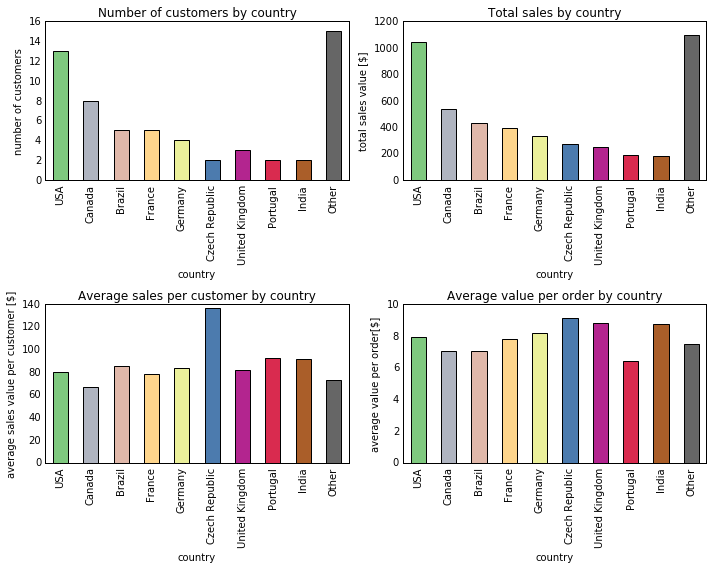

In [11]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_data.shape[0])]
fig, axes = plt.subplots(2,2,figsize=(10,8))

country_data.plot.bar("country","num_customers",ax=axes[0,0],rot=90,color=colors,legend=False)
axes[0,0].set_ylabel("number of customers")
axes[0,0].set_title("Number of customers by country")
axes[0,0].tick_params(top="off", right="off", left="off", bottom="off")

country_data.plot.bar("country","tot_sales_value",ax=axes[0,1],rot=90,color=colors,legend=False)
axes[0,1].set_ylabel("total sales value [$]")
axes[0,1].set_title("Total sales by country")
axes[0,1].tick_params(top="off", right="off", left="off", bottom="off")

country_data.plot.bar("country","avg_sales_per_cust",ax=axes[1,0],rot=90,color=colors,legend=False)
axes[1,0].set_ylabel("average sales value per customer [$]")
axes[1,0].set_title("Average sales per customer by country")
axes[1,0].tick_params(top="off", right="off", left="off", bottom="off")

country_data.plot.bar("country","avg_order_value",ax=axes[1,1],rot=90,color=colors,legend=False)
axes[1,1].set_ylabel("average value per order[$]")
axes[1,1].set_title("Average value per order by country")
axes[1,1].tick_params(top="off", right="off", left="off", bottom="off")

plt.tight_layout()

Given the average sales per customer in each country, it appears that the Czech Republic, Portugal, and India have the largest growth potential--i.e. getting more customers in those countries would increase revenue the most.

Given the average value per order in each country, it appears that the Czech Republic, United Kingdom, and India have the largest growth potential--i.e. getting more orders in those countries would increase revenue the most.

### For each invoice, determine if it is an album purchase or not

In [29]:
# each track_id is only associated with on album id
# query = '''
#         SELECT track_id,
#                COUNT(DISTINCT(album_id)) num_albums
#         FROM track
#         GROUP BY track_id
#         ORDER BY num_albums DESC
#         '''

query = '''
        WITH 
        
        album_tracks AS 
        (
            SELECT a.album_id album_id,
                   t.track_id as track_id
            FROM album a 
            LEFT JOIN track t ON t.album_id = a.album_id
            ORDER BY 1,2
        ),
        
        num_album_tracks AS
        (
            SELECT album_id,
                   COUNT(DISTINCT(track_id)) as tot_num_tracks
            FROM album_tracks 
            GROUP BY album_id
        ),
        
        invoice_purchases AS
        (
            SELECT i.invoice_id,
                   t.track_id,
                   a.album_id album_id
            FROM invoice i
            LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
            LEFT JOIN track t ON t.track_id = il.track_id
            LEFT JOIN album a ON a.album_id = t.album_id
        ),
        
        invoice_purchases_num_tracks AS
        (
            SELECT invoice_id,
                   album_id,
                   COUNT(DISTINCT(track_id)) num_tracks_purchased
            FROM invoice_purchases
            GROUP BY invoice_id, album_id
        ),
        
        album_purchases AS
        (
            SELECT i.invoice_id,
                   CASE WHEN 
                       i.num_tracks_purchased = a.tot_num_tracks 
                       THEN 1
                       ELSE 0
                       END
                       album_purchase
            FROM invoice_purchases_num_tracks i
            LEFT JOIN num_album_tracks a ON a.album_id = i.album_id
        ),
        
        invoice_album_purchases AS
        (
            SELECT invoice_id,
                   CASE WHEN SUM(album_purchase) > 0 
                   THEN "yes"
                   ELSE "no"
                   END
                   invoice_album_purchase
            FROM album_purchases
            GROUP BY invoice_id
        )
        
        SELECT invoice_album_purchase,
               COUNT(invoice_id) num_invoices,
               100*CAST(COUNT(invoice_id) as FLOAT) / 
                 (SELECT COUNT(*) FROM invoice_album_purchases) 
               pct_invoices
        FROM invoice_album_purchases
        GROUP BY invoice_album_purchase
        '''

# wanted to run the query this way, but had trouble making sense
# of it
# query = '''        
#         WITH 
        
#         album_tracks AS 
#         (
#         SELECT a.album_id album_id,
#                t.track_id as track_id
#         FROM album a 
#         LEFT JOIN track t ON t.album_id = a.album_id
#         ORDER BY 1,2
#         ),
        
#         invoice_purchases AS
#         (
#         SELECT i.invoice_id,
#                a.album_id,
#                t.track_id
#         FROM invoice i
#         LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
#         LEFT JOIN track t ON t.track_id = il.track_id
#         LEFT JOIN album a ON a.album_id = t.album_id
#         ORDER BY i.invoice_id
#         )
        
#         SELECT i.invoice_id,
#                i.album_id,
#                CASE WHEN (SELECT track_id 
#                           FROM album_tracks
#                           EXCEPT
#                           SELECT track_id
#                           FROM invoice_purchases
#                           ) 
#                           IS NULL

#                           AND

#                          (SELECT track_id 
#                           FROM album_tracks
#                           EXCEPT
#                           SELECT track_id
#                           FROM invoice_purchases
#                           ) 
#                           IS NULL  

#                           THEN 1
#                           ELSE 0
#                           END
#                           full_album
#         FROM invoice_purchases i
#         GROUP BY invoice_id, album_id         
#      '''



album_data = run_query(query)
album_data

,invoice_album_purchase,num_invoices,pct_invoices
0,no,413,67.263844
1,yes,201,32.736156


Based on this, about 32% of purchases contain an album purchase, so it makes sense for the Chinook store to continue to buy full albums.